In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, time, timedelta
from dateutil import parser
from matplotlib.lines import Line2D
import seaborn as sns
import os
import numpy as np
from scipy import stats

In [58]:
all_data_with_ICE_interaction = {}
all_data_without_ICE_interaction = {}
ICE_services = [140, 142, 144, 146, 148, 240, 242]
stations = ['Hengelo', 'Deventer', 'Apeldoorn', 'Amersfoort Centraal']
o_services = ['7900', '1700', '3600', '31300', '31400','1500', '31200', '7000', '17900']

file_s = f'Services/all_interesting_services_complete_day.csv'
df = pd.read_csv(file_s, sep = ',')
df['Stop:Departure time'] = pd.to_datetime(df['Stop:Departure time'], utc=True, format='mixed', dayfirst=True)
df['Stop:Arrival time'] = pd.to_datetime(df['Stop:Arrival time'], utc=True, format='mixed', dayfirst=True)
df['Service:Date'] = pd.to_datetime(df['Service:Date'], format='mixed', dayfirst=True)
display(df)

,Service:RDT-ID,Service:Date,Service:Type,Service:Company,Service:Train number,Service:Completely cancelled,Service:Partly cancelled,Service:Maximum delay,Stop:RDT-ID,Stop:Station code,Stop:Station name,Stop:Arrival time,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled,Stop:Platform change,Stop:Planned platform,Stop:Actual platform
0,12690890,2024-01-01,Intercity,NS Int,240,False,False,0,114307809,BH,Bad Bentheim,2024-01-01 08:48:00+00:00,0.0,False,2024-01-01 08:51:00+00:00,0.0,False,False,NaN,NaN
1,12690890,2024-01-01,Intercity,NS Int,240,False,False,0,114307810,HGL,Hengelo,2024-01-01 09:07:00+00:00,0.0,False,2024-01-01 09:09:00+00:00,1.0,False,False,2,2
2,12690890,2024-01-01,Intercity,NS Int,240,False,False,0,114307811,DV,Deventer,2024-01-01 09:41:00+00:00,0.0,False,2024-01-01 09:45:00+00:00,0.0,False,True,3,4
3,12690890,2024-01-01,Intercity,NS Int,240,False,False,0,114307812,APD,Apeldoorn,2024-01-01 09:57:00+00:00,0.0,False,2024-01-01 09:59:00+00:00,0.0,False,False,1,1
4,12690890,2024-01-01,Intercity,NS Int,240,False,False,0,114307813,AMF,Amersfoort Centraal,2024-01-01 10:24:00+00:00,0.0,False,2024-01-01 10:26:00+00:00,0.0,False,False,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871200,17108260,2025-10-31,Sprinter,Blauwnet,7994,False,False,0,154721269,ESK,Enschede Kennispark,2025-10-31 23:39:00+00:00,0.0,False,2025-10-31 23:39:00+00:00,0.0,False,False,1,1
871201,17108260,2025-10-31,Sprinter,Blauwnet,7994,False,False,0,154721270,HGL,Hengelo,2025-10-31 23:43:00+00:00,0.0,False,NaT,NaN,NaN,False,2b,2b
871202,17108301,2025-10-31,Sprinter,RRReis,31378,False,False,0,154721544,BNN,Barneveld Noord,2025-11-01 00:17:00+00:00,2.0,False,2025-11-01 00:17:00+00:00,3.0,False,False,1,1
871203,17108301,2025-10-31,Sprinter,RRReis,31378,False,False,0,154721545,HVL,Hoevelaken,2025-11-01 00:24:00+00:00,4.0,False,2025-11-01 00:24:00+00:00,4.0,False,False,1,1


In [ ]:
### INTERACTION AT STATIONS ###

headway = 3
dwelltimes = {'Hengelo':2, 'Deventer': 6, 'Apeldoorn':2, 'Amersfoort Centraal': 2}
delays = ['Arrival', 'Departure']
delay_max = 60
no_interaction = df.copy()

total = 0

### SECONDARY PLOT ###
for delay in delays:
    for i in stations:
        ICE_station = 'Hengelo'
        interaction_all_services = []                       #All interactions for every service + the delay of the ICE at Hengelo are added in this dataframe
        for x in ICE_services:                              #For every ICE service the interactions are identified
            ICE_H = df[
                (df['Service:Train number'] == x) &         #Train is the ICE service
                (df['Stop:Station name'] == ICE_station) &  #Station 
                (df['Service:Partly cancelled']==False) &   #Only non-canceled train
                (df[f'Stop:Arrival delay'] <= delay_max) &  #Only delays of the ICE smaller than the delay_max are considered
                (df[f'Stop:Arrival delay'] >= 3)            #Only delays of the ICE larger than 3 are considered
            ][['Service:Date', f'Stop:Arrival delay']]
            ice_hengelo = ICE_H.rename(columns={f'Stop:Arrival delay': f'ICE Delay {ICE_station}'})

            ice_time_at_station = df[
                (df['Service:Train number'] == x) &
                (df['Stop:Station name'] == i)
            ][['Service:Date', f'Stop:Arrival time', f'Stop:Arrival delay']].rename(columns={f'Stop:Arrival time': f'ICE_Arrival_time'})
            ice_time_at_station[f'Actual_ICE_Arrival_Time_{i}'] = ice_time_at_station[f'ICE_Arrival_time'] + pd.to_timedelta(ice_time_at_station[f'Stop:Arrival delay'], unit = 'm')
            ice_time_at_station

            other_trains = df[
                (df['Service:Train number'] != x) & 
                (df['Stop:Station name'] == i)
            ][['Service:Date', 'Service:Train number', 'Stop:RDT-ID', f'Stop:{delay} time', f'Stop:{delay} delay']].rename(columns={f'Stop:{delay} delay': f'Other {delay} Delay {i}', f'Stop:{delay} time': f'Other_{delay}_time'})
            other_trains[f'Actual_Other_{delay}_Time_{i}'] = other_trains[f'Other_{delay}_time'] + pd.to_timedelta(other_trains[f'Other {delay} Delay {i}'], unit='m')

            ice_vs_allservices = pd.merge(other_trains, ice_time_at_station, on='Service:Date')   # 
            ice_vs_allservices['Time_Diff_Minutes'] = (ice_vs_allservices[f'Actual_Other_{delay}_Time_{i}'] - ice_vs_allservices[f'Actual_ICE_Arrival_Time_{i}']).dt.total_seconds() / 60

            if delay == "Arrival":
                interaction = ice_vs_allservices[(ice_vs_allservices['Time_Diff_Minutes'] >= - headway) & (ice_vs_allservices['Time_Diff_Minutes'] <= headway + dwelltimes[i])].copy()
            elif delay == 'Departure':
                interaction = ice_vs_allservices[(ice_vs_allservices['Time_Diff_Minutes'] >= -(headway + dwelltimes[i])) & (ice_vs_allservices['Time_Diff_Minutes'] <= headway)].copy()
            
            iceh_vs_allservices = pd.merge(interaction, ice_hengelo, on='Service:Date')
            interaction_all_services.append(iceh_vs_allservices)

            ids_with_interaction = interaction['Stop:RDT-ID'].unique()
            no_interaction = no_interaction[~no_interaction['Stop:RDT-ID'].isin(ids_with_interaction)]

        plot_data = pd.concat(interaction_all_services, ignore_index=True)  #interactions of all ICE services combined
        if plot_data.empty:
            continue
        plot_data['Series Group'] = plot_data['Service:Train number'].astype(str).str[:-2] + '00 Series'
        plot_data = plot_data[(plot_data['Series Group'] != '100 Series') & (plot_data['Series Group'] != '200 Series')  & (plot_data['Series Group'] != '20300 Series')]
        if delay == "Arrival":
            all_data_with_ICE_interaction[i] = plot_data

        sns.set_style("whitegrid")

        # g = sns.relplot(
        #     data=plot_data,
        #     x=f'ICE Delay {ICE_station}',
        #     y=f'Other {delay} Delay {i}',
        #     col='Series Group',           
        #     hue='Series Group',    
        #     kind='scatter',
        #     palette='tab10',
        #     height=5,                      
        #     aspect=1.2,                     
        #     s=100,
        #     alpha=0.2,
        #     col_wrap=2                     
        # )
        # g.fig.suptitle(f'Secondary {delay} Delay National Trains With Interaction ICE At {i}', y=1.02, fontsize = 17, color= 'black')
        # plt.show()
        # folder = "ICE Delay at station"
        # save_path = os.path.join(folder, f"{i}, {delay} ({delay_max} min).png")
        # g.figure.savefig(save_path, dpi=300, bbox_inches="tight")

        # plt.close(g.figure)
display(no_interaction)

,Service:RDT-ID,Service:Date,Service:Type,Service:Company,Service:Train number,Service:Completely cancelled,Service:Partly cancelled,Service:Maximum delay,Stop:RDT-ID,Stop:Station code,Stop:Station name,Stop:Arrival time,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled,Stop:Platform change,Stop:Planned platform,Stop:Actual platform
0,12690890,2024-01-01,Intercity,NS Int,240,False,False,0,114307809,BH,Bad Bentheim,2024-01-01 08:48:00+00:00,0.0,False,2024-01-01 08:51:00+00:00,0.0,False,False,NaN,NaN
1,12690890,2024-01-01,Intercity,NS Int,240,False,False,0,114307810,HGL,Hengelo,2024-01-01 09:07:00+00:00,0.0,False,2024-01-01 09:09:00+00:00,1.0,False,False,2,2
2,12690890,2024-01-01,Intercity,NS Int,240,False,False,0,114307811,DV,Deventer,2024-01-01 09:41:00+00:00,0.0,False,2024-01-01 09:45:00+00:00,0.0,False,True,3,4
3,12690890,2024-01-01,Intercity,NS Int,240,False,False,0,114307812,APD,Apeldoorn,2024-01-01 09:57:00+00:00,0.0,False,2024-01-01 09:59:00+00:00,0.0,False,False,1,1
4,12690890,2024-01-01,Intercity,NS Int,240,False,False,0,114307813,AMF,Amersfoort Centraal,2024-01-01 10:24:00+00:00,0.0,False,2024-01-01 10:26:00+00:00,0.0,False,False,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871200,17108260,2025-10-31,Sprinter,Blauwnet,7994,False,False,0,154721269,ESK,Enschede Kennispark,2025-10-31 23:39:00+00:00,0.0,False,2025-10-31 23:39:00+00:00,0.0,False,False,1,1
871201,17108260,2025-10-31,Sprinter,Blauwnet,7994,False,False,0,154721270,HGL,Hengelo,2025-10-31 23:43:00+00:00,0.0,False,NaT,NaN,NaN,False,2b,2b
871202,17108301,2025-10-31,Sprinter,RRReis,31378,False,False,0,154721544,BNN,Barneveld Noord,2025-11-01 00:17:00+00:00,2.0,False,2025-11-01 00:17:00+00:00,3.0,False,False,1,1
871203,17108301,2025-10-31,Sprinter,RRReis,31378,False,False,0,154721545,HVL,Hoevelaken,2025-11-01 00:24:00+00:00,4.0,False,2025-11-01 00:24:00+00:00,4.0,False,False,1,1


In [60]:
### Punctuality with and without ICE ###

# ---- with ICE ---- #
table = pd.DataFrame(columns = ['Station', 'Train series', 'Punctuality with ICE interaction'])
w_ICE = {}

for i in stations:
    df1 = all_data_with_ICE_interaction[i]
    for j in o_services:
        trainseries = j[:-2]
        filtered_df1 = df1[(df1['Service:Train number'].astype(str).str[:-2] == trainseries )] 
        if filtered_df1.empty:
            continue
        trains_delay = filtered_df1[f'Other Arrival Delay {i}'].tolist()

        w_ICE[f'{i}, {j}'] = trains_delay


# ---- without ICE ---- #
wo_ICE = {}
for i in stations:
    df1 = no_interaction[no_interaction['Stop:Station name'] == i]
    for j in o_services:
        trainseries = j[:-2]
        filtered_df1 = df1[(df1['Service:Train number'].astype(str).str[:-2] == trainseries ) ] 
        if filtered_df1.empty:
            continue
        trains_delay = filtered_df1['Stop:Arrival delay'].tolist()  
        wo_ICE[f'{i}, {j}'] = trains_delay


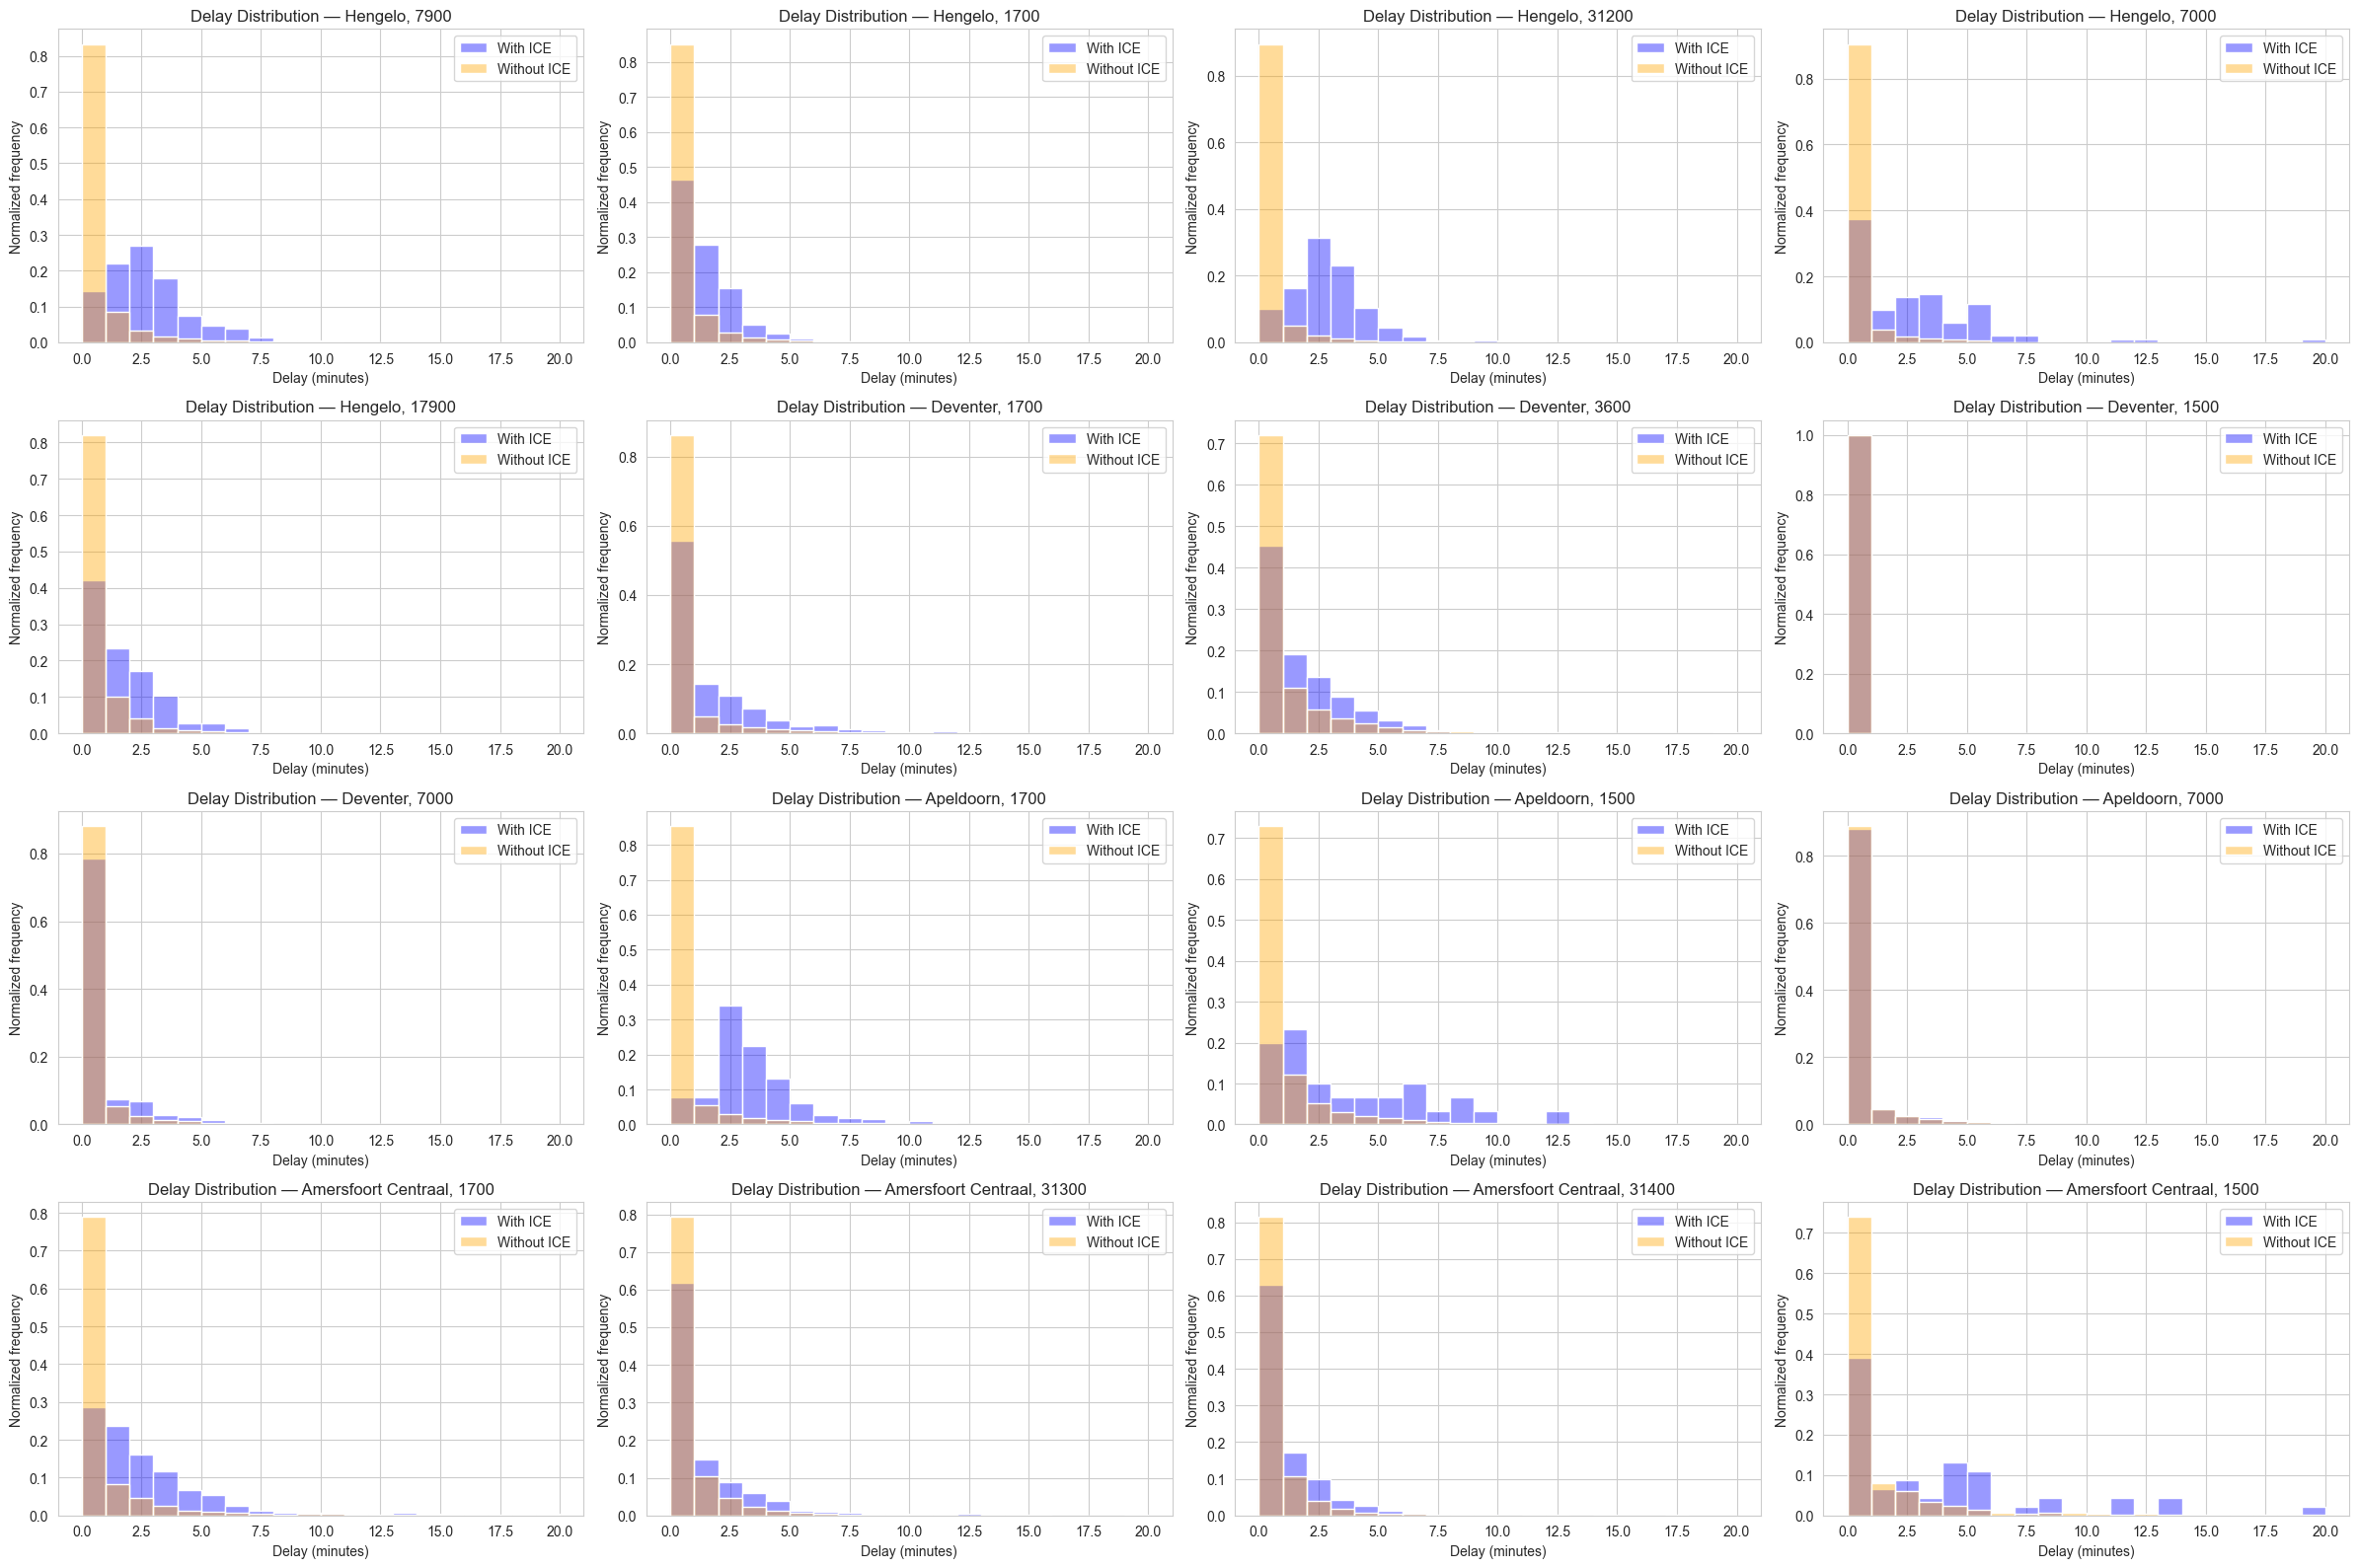

In [ ]:
### VISUALIZATION ###
# ---- Delay distribution ---- #
keys = list(w_ICE.keys())
N = len(keys)

cols = int(np.ceil(np.sqrt(N)))
rows = int(np.ceil(N / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))

if N == 1:
    axes = np.array([axes])
else:
    axes = axes.flatten()

for i, key in enumerate(keys):
    ax = axes[i] 
    data1 = np.array(w_ICE[key], dtype=float)
    data2 = np.array(wo_ICE[key], dtype=float)

    data1 = data1[~np.isnan(data1)]
    data2 = data2[~np.isnan(data2)]


    if len(data1) == 0 and len(data2) == 0:
        ax.set_visible(False) 
        continue

    combined_data = np.concatenate([data1, data2])
    if combined_data.size > 0:
        min_val = 0
        max_val = 20
        # Using 30 bins; adjust this number (e.g., 50) for more detail
        bins = np.linspace(min_val, max_val, 21) 
    else:
        continue # Skip if no data remains

    # 2. Use sns.histplot instead of sns.kdeplot
    # stat="density" normalizes the bars so their area sums to 1.
    sns.histplot(data1, ax=ax, bins=bins, stat="density", alpha=0.4, label="With ICE", color="blue")
    sns.histplot(data2, ax=ax, bins=bins, stat="density", alpha=0.4, label="Without ICE", color="orange")
    
    # --- HISTOGRAM CHANGES END ---

    ax.set_xlabel("Delay (minutes)")
    ax.set_ylabel("Normalized frequency")
    ax.set_title(f"Delay Distribution — {key}")

    ax.legend()
    ax.grid(True)

for i in range(N, rows * cols):
    axes[i].set_visible(False)

fig.tight_layout()

# Changed the filename to reflect the new plot type
plt.savefig('Secondary_Delay_Distribution_Histogram.png') 


In [ ]:
### MEAN PUNCTUALITY DIFFERENCE ###

# ---- with ICE ---- #
table = pd.DataFrame(columns = ['Station', 'Train series', 'Punctuality with ICE interaction'])


delay_def = 3


for i in stations:
    df = all_data_with_ICE_interaction[i]
    for j in o_services:
        trainseries = j[:-2]
        filtered_df1 = df[(df['Service:Train number'].astype(str).str[:-2] == trainseries )] 
        if filtered_df1.empty:
            continue
        total_trains = len(filtered_df1)
        trains_delay = (filtered_df1[f'Other Arrival Delay {i}'] >= delay_def).sum()
        share = 100-(int(trains_delay)/int(total_trains) * 100)
        data = [i,j, round(share, 1)]
        table.loc[len(table)] = data 
        

# ---- without ICE ---- #
for i in stations:
    df1 = no_interaction[no_interaction['Stop:Station name'] == i]
    for j in o_services:
        trainseries = j[:-2]
        filtered_df1 = df1[(df1['Service:Train number'].astype(str).str[:-2] == trainseries ) & (df1['Stop:Station name'] == i )] 
        if filtered_df1.empty:
            continue
        total_trains = len(filtered_df1)
        trains_delay = (filtered_df1[f'Stop:Arrival delay'] > delay_def).sum()  #A train is delayed is the delay is larger than the definition of a delay
        share = 100-(int(trains_delay)/int(total_trains) * 100)
        table.loc[(table['Station'] == i) & (table['Train series'] == j), 'Punctuality Overall'] = round(share, 1)

table['Punctuality Difference'] = table['Punctuality with ICE interaction'] - table['Punctuality Overall']


for i in stations:
    df = all_data_with_ICE_interaction[i] # Data source 1 (station-specific)
    df1 = no_interaction[no_interaction['Stop:Station name'] == i]
    for j in o_services:
        trainseries = j[:-2]
        filtereddf1 = df[ (df['Service:Train number'].astype(str).str[:-2] == trainseries ) ]

        filtereddf2 = df1[ (df1['Service:Train number'].astype(str).str[:-2] == trainseries ) & (df1['Stop:Station name'] == i ) ]

        data1 = np.array(filtereddf1[f'Stop:Arrival delay'].tolist())
        data2 = np.array(filtereddf2[f'Stop:Arrival delay'].tolist())
        # --- OPTIMIZATION STEP 2: Check for valid data lengths ---
        if len(data1) < 2 or len(data2) < 2:
            continue 

        # t-test remains correct for comparing two independent, unequally-sized samples
        t_statistic, p_value = stats.ttest_ind(
            data1,
            data2,
            equal_var=False) # Correctly using Welch's t-test
            
        print(f"Results: {i}, {j}")
        print(f"T-statistic: {t_statistic:.4f}")
        print(f"P-value: {p_value:.4f}")


table.to_excel(f'Impact of ICE Interaction on Mean Punctuality (Arrival) per Train Series.xlsx', index=False)
print(table)


782
22074
Results: Hengelo, 7900
T-statistic: nan
P-value: nan
569
15878
Results: Hengelo, 1700
T-statistic: nan
P-value: nan
742
21704
Results: Hengelo, 31200
T-statistic: nan
P-value: nan
102
3578
Results: Hengelo, 7000
T-statistic: 28.4946
P-value: 0.0000
145
5954
Results: Hengelo, 17900
T-statistic: nan
P-value: nan
766
15123
Results: Deventer, 1700
T-statistic: nan
P-value: nan
1006
20578
Results: Deventer, 3600
T-statistic: nan
P-value: nan
2
5460
Results: Deventer, 1500
T-statistic: nan
P-value: nan
936
19690
Results: Deventer, 7000
T-statistic: nan
P-value: nan
461
16647
Results: Apeldoorn, 1700
T-statistic: nan
P-value: nan
30
5488
Results: Apeldoorn, 1500
T-statistic: nan
P-value: nan
672
19312
Results: Apeldoorn, 7000
T-statistic: 41.5456
P-value: 0.0000
494
16447
Results: Amersfoort Centraal, 1700
T-statistic: nan
P-value: nan
503
23206
Results: Amersfoort Centraal, 31300
T-statistic: 21.5447
P-value: 0.0000
350
13019
Results: Amersfoort Centraal, 31400
T-statistic: 41.5821

**Treinseries:**<br>
         1700: Enschede - Den Haag Centraal<br>
         7000: Almelo - Apeldoorn<br>
         7900: Enschede - Zwolle<br>
         3600: Zwolle - Roosendaal<br>
         31300: Amersfoort - Ede-Wageningen<br>
         31400: Amersfoort - Barneveld-Zuid<br>
         17900: Enschede - Zwolle IC<br>
         31200: Zutphen - Oldenzaal<br>
         1500: Deventer - Amsterdam"

